In [1]:
import os
import sys
import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, gs

# Set strong lens parameters

In [2]:
lens = SampleStrongLens()

num_pix = 51
side = 5.61
output_size = 45
band = 'F184'
oversample = 5

In [3]:
# add CDM subhalos; NB same subhalo population for all
realization = util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample.pkl'))
lens.add_subhalos(realization)

model = lens.get_array(num_pix=51 * oversample, side=5.61, band=band)
util.pickle(os.path.join(array_dir, 'sample_strong_lens.pkl'), lens)
np.save(os.path.join(array_dir, 'sample_strong_lens.npy'), model)

KeyboardInterrupt: 

In [4]:
lens = util.unpickle(os.path.join(array_dir, 'sample_strong_lens.pkl'))
model = np.load(os.path.join(array_dir, 'sample_strong_lens.npy'))

# Simulate Pandeia image

In [5]:
num_samples = 1e3
calc, num_point_sources = pandeia_input.build_pandeia_calc(array=model, lens=lens, band=band, num_samples=num_samples, max_scene_size=side, suppress_output=False)
pandeia_image, execution_time = pandeia_input.get_pandeia_image(calc, suppress_output=False)

pandeia_image = util.center_crop_image(pandeia_image, (output_size, output_size))

np.save(os.path.join(array_dir, 'pandeia_image.npy'), pandeia_image)

100%|██████████| 877/877 [00:06<00:00, 144.68it/s]


Point source conversion complete: placed 877 point sources
Estimated calculation time: 0:01:09
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:31


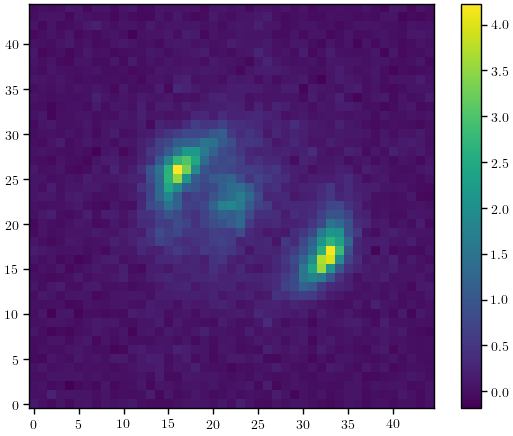

In [6]:
pandeia_image = np.load(os.path.join(array_dir, 'pandeia_image.npy'))
plot.plot(pandeia_image, colorbar=True)

# Simulate Galsim image

In [14]:
detector = 1
detector_pos = (2048, 2048)

results, execution_time = gs.get_images(lens, model, band, input_size=num_pix, output_size=output_size,
                                            grid_oversample=oversample, psf_oversample=oversample,
                                            detector=detector,
                                            detector_pos=detector_pos, exposure_time=146, ra=26, dec=-33,
                                            seed=None, validate=True, suppress_output=False)
galsim_image = results[0]

np.save(os.path.join(array_dir, 'galsim_image.npy'), galsim_image)

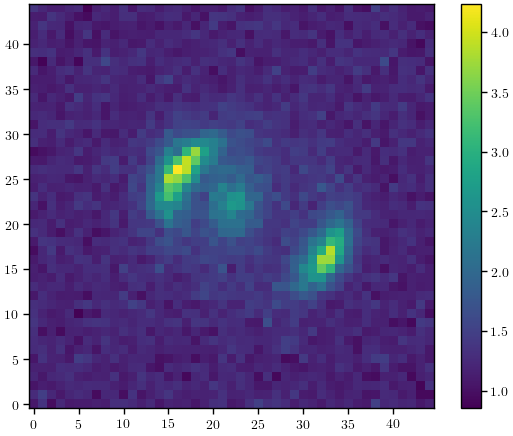

In [15]:
galsim_image = np.load(os.path.join(array_dir, 'galsim_image.npy'))
plot.plot(galsim_image, colorbar=True)

# Compare

In [16]:
pandeia_image = np.load(os.path.join(array_dir, 'pandeia_image.npy'))
galsim_image = np.load(os.path.join(array_dir, 'galsim_image.npy'))

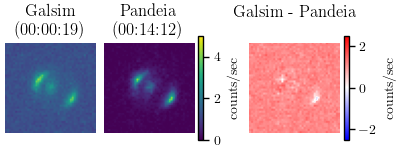

In [37]:
f, ax = plt.subplots(1, 3, figsize=(4, 1.5), constrained_layout=True)

ax[0].imshow(galsim_image, vmin=0, vmax=5)
ax[0].set_title('Galsim\n(00:00:19)')
ax[0].set_axis_off()

axis = ax[1].imshow(pandeia_image, vmin=0, vmax=5)
ax[1].set_title('Pandeia\n(00:14:12)')
ax[1].set_axis_off()

cbar = f.colorbar(axis, ax=ax[1])
cbar.set_label('counts/sec', rotation=90)

# ax[2].imshow(plot_util.normalize(pandeia_image) - plot_util.normalize(galsim_image), cmap='bwr', vmin=-0.1, vmax=0.1)
# ax[2].set_title(f'pandeia - galsim, $\chi^2=$ {round(stats.chi2_distance(plot_util.normalize(pandeia_image), plot_util.normalize(galsim_image)), 3)}')
axis_residual = ax[2].imshow(galsim_image - pandeia_image, cmap='bwr', vmin=-2.5, vmax=2.5)
# ax[2].set_title(f'pandeia - galsim, $\chi^2=$ {round(stats.chi2_distance(plot_util.normalize(pandeia_image), plot_util.normalize(galsim_image)), 3)}')
ax[2].set_title(f'Galsim - Pandeia\n')
ax[2].set_axis_off()

cbar_res = f.colorbar(axis_residual, ax=ax[2])
cbar_res.set_label('counts/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'galsim_pandeia_compare.png'))
plt.show()